# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>



## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 

random.seed(42) #Set a seed for replicable results


We'll store the a/b data in a Pandas DataFrame. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.shape

(294478, 5)

In [4]:
df['user_id'].nunique()

290584

In [5]:
(df['converted'] == 1).sum()/df.shape[0]

0.11965919355605512

In [6]:
(df[df['group'] == 'treatment']['landing_page'] != 'new_page').sum()

1965

In [7]:
df.isnull().any(axis=1).sum()

0

Findings: almost 300k rows, some user_id's are duplicates, about 11.97% of all rows have a converted value of 1, some subjects are in the wrong landing page group, and there are no null values. 

Addressing the "incorrect" groups, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  We'll address this below:

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "control" and landing_page == "old_page")or(group == "treatment" and landing_page == "new_page")')


In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

We'll take a look again at duplicate user ids:

In [11]:
df2.loc[df2['user_id'].duplicated(),:]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2.loc[df2['user_id'].duplicated(keep=False),:]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The timestamp is different, but it's still a duplicate. Since the group and landing pages match, we'll just remove one of them.

In [2]:
df2 = df2.drop(2893) #Remove one of the rows with a duplicate user_id
df2.loc[df2['user_id'].duplicated(keep=False),:] #Verify

NameError: name 'df2' is not defined

### ToDo 1.4  


What is the probability of an individual converting regardless of the page they receive?


In [14]:
p_population = df2['converted'].mean()
p_population

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

What's the observed difference in our sample?

In [3]:
obs_diff = p_treatment - p_control
obs_diff

NameError: name 'p_treatment' is not defined

What is the probability that an individual received the new page?

In [20]:
p_new_page = (df2['group'] == 'treatment').mean()
p_new_page

0.50006194422266881

Seeing that there's an even distribution between the control and treatment groups, and being in the treatment group actually lead to a decrease in conversion by 0.16%, we can conclude that based on our dataset, being in the treatment group, or being lead to the new page, does not lead to a higher conversion rate on average.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  


For now, we'll make the decision just based on all of the data provided at the time of procurement. .  

We assume that the the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, meaning that our null hypothesis would be: 

# $$ H_0: p_{new} - p_{old} \leq 0$$ 


Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we'll complete the following: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



In [21]:
# take our population conversion rate calculated before and assign its value
# to p_new
p_new = p_population
p_new

0.11959708724499628

In [22]:
# take our population conversion rate calculated before and assign its value
# to p_old

p_old = p_population
p_old

0.11959708724499628

In [23]:
n_new = (df2['landing_page'] == 'new_page').sum()
n_new

145310

In [24]:
n_old = (df2['landing_page'] == 'old_page').sum()
n_old

145274

**Simulate Sample for the `treatment` Group**<br> 

We'll simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis. 


In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],p=[1-p_new, p_new],size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

**Simulate Sample for the `control` Group** <br>

We'll simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. 

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],p=[1-p_old,p_old],size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

We now find difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for the simulated samples

In [27]:
new_page_converted.mean() - old_page_converted.mean()

6.0008721252960417e-05


**Sampling distribution** <br>
To create a nice normal distribution under the null, we re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used before.


In [28]:
# Sampling distribution
p_diffs = []

for i in range(10000):
    sample_p_new = np.random.choice([0,1],p=[1-p_new, p_new],size=n_new)
    sample_p_old = np.random.choice([0,1],p=[1-p_old,p_old],size=n_old)
    p_diff = sample_p_new.mean() - sample_p_old.mean()
    p_diffs.append(p_diff)
    

**Histogram**

Text(0.5,1,'Difference in sampled means')

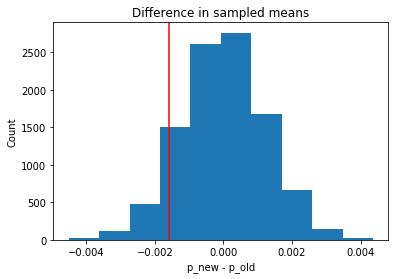

In [29]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label='huh')
plt.xlabel('p_new - p_old')
plt.ylabel('Count')
plt.title('Difference in sampled means')

What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
greater_than_obs_diff = []

for i in range(len(p_diffs)):
    if p_diffs[i] > obs_diff:
        greater_than_obs_diff.append(p_diffs[i])

proportion_greater = len(greater_than_obs_diff)/len(p_diffs)
proportion_greater

0.9099



0.9099 would be the ***p-value***, which signifies how likely we are to observe our findings from the samples given the assumption that the null hypothesis holds true.

If our Type I error rate is 0.05, we require a p-value less than or equal to 5% in order to reject our null hypothesis. In the context of our test results, 0.91 is much higher than 0.05, so we fail to reject the null hypothesis. Our p-value signfies that it is extremely likely that the observed difference from the previous section would have been observed under our null hypothesis



**Turning to Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = (df2[df2['group'] == "control"]['converted'] == 1).sum()

# number of conversions with the new_page
convert_new = (df2[df2['group'] == "treatment"]['converted'] == 1).sum()

# number of individuals who were shown the old_page
n_old = (df2['group'] == "control").sum()

# number of individuals who received new_page
n_new = (df2['group'] == "treatment").sum()


Using `sm.stats.proportions_ztest()`, we can compute the test statistic and p-value. The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 


The built-in function above will return the z_score, p_value. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test.

In [32]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The $Z_{score}$ and p-value calculated by statsmodels' proportions_ztest supports our failure to reject the null hypothesis earlier.  The $Z_{score}$ of -1.311 is less than $Z_{\alpha}$, which is 1.645.  Additionally, our p-value of 0.905 is much higher than the required value of 0.05 to reject the null hypothesis, and thus we fail to reject it.

<a id='regression'></a>
### Part III - A regression approach

In this final part, will experiment with replicating the results of the A/B test above by instead performing regression, specifically logistic regression.

In [33]:
df2['intercept'] = 1
df2[['not_ab_page','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('not_ab_page',axis=1)

We can use statsmodels to instantiate the regression model on the two columns created above, then fit the model to predict whether or not an individual converts. 


In [34]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-01 10:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [35]:
np.exp(-.015)

0.98511193960306265

The coefficient of ab_page and in the summary and its resulting exponentiated value of 0.986 indicates that if the individual is in the treatment group, they are 0.985x as likely (or in other words, slightly less likely) to convert in comparision to individuals who are in the control group. Our p-value is 0.19, and its difference from our previous p-values results from the fact that the logistic regression model is testing a two-sided hypothesis rather than our previously one-sided hypothesis. Despite it being much less than before, it is still higher than the type I error rate of 0.05, and we are still unable to reject our new null hypothesis that being in the treatment group results in the same conversion rate as being in the control group.

Including other factors to our models allows us to detect whether there are other variables that would give us stronger predictions in the resulting dependent variable that we're measuring.  However, if we add additional terms that are incomplete, we may be mislead to make conclusions that don't actually reflect the relationship between the new independent variables and the dependent variable.

Now along with testing if the conversion rate changes for different pages, we could also add the factor of which country a user lives in. We'll implement the countries.csv file for this.

In [36]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')

In [37]:
# Join with the df2 dataframe
df_merged = df2.join(countries.set_index('user_id'),on='user_id')

In [38]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])

In [39]:
# Does it appear that country had an impact on conversion? 

#using US as baseline
logit_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','CA','UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-01 10:41 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [40]:
np.exp(-.041),np.exp(.01)

(0.9598291299477989, 1.0100501670841679)

Using the US as our baseline, we see that individuals from CA are 0.96x as likely to convert as individuals from the US, and individuals from the UK are 1.01x as likely to convert as individuals from the US.  Neither P-value for these statistics falls below 0.05, so we fail to reject our new null hypotheses that conversion rates are different between individuals from US vs CA or US vs UK.
However, an individual being from UK vs being from CA may have an impact on conversion rate, so we will use the UK as our baseline next.

In [41]:
#using UK as baseline

logit_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','US','CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-01 10:41 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

In [42]:
np.exp(-.051)

0.95027867053242698

Using UK as our baseline, we see that individuals from CA are 0.95x as likely to convert.  The p-value for this is the lowest we've seen so far, 0.074, however it is still above our Type I error rate of 0.05, so we still fail to reject our null hypotheses that country has no impact on conversion rate.

Though we have now looked at the individual factors of country and page on conversion, we could now like to look at an interaction between page and country to see if are there significant effects on conversion. 


In [43]:
df_merged['CA_treatment'] = (df_merged['ab_page'])*(df_merged['CA'])
df_merged['UK_treatment'] = (df_merged['ab_page'])*(df_merged['UK'])
df_merged['US_treatment'] = (df_merged['ab_page'])*(df_merged['US'])

In [44]:
#First, we'll use US as a baseline

logit_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','CA_treatment','UK_treatment']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-01 10:43 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9963   0.0062 -322.0487 0.0000 -2.0084 -1.9841
CA_treatment     -0.0752   0.0376   -1.9974 0.0458 -0.1489 -0.0014
UK_treatment      0.0149   0.0173    0.8617 0.3888 -0.0190  0.0488
==================================================================

"""

In [45]:
np.exp(-0.075),np.exp(0.015)

(0.92774348632855286, 1.0151130646157189)

People in the treatment group from the US do not have a statistically significant conversion rate difference when compared to people in the treatment group from the UK. However, not only does the CA_treatment group have a more noticeable difference in conversion rate (0.928 as likely to convert, or almost 8% less likely to convert), the p-value of 0.046 for this rate falls below our type I error rate of 0.05, meaning that we can reject the null hypothesis that the conversion rates between individuals from the US who were given the new page and individuals from CA who were given the new page are no different from each other, in favor of the alternative hypothesis that the conversion rates between these two groups are not the same. 

Next, we'll use the UK_treatment as our baseline so we may compare the groups UK_treatment and CA_treatment.*

In [46]:
logit_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','CA_treatment','US_treatment']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-01 10:43 AIC:              212777.1060
No. Observations:   290584           BIC:              212808.8450
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9873   0.0072 -275.5728 0.0000 -2.0014 -1.9732
CA_treatment     -0.0842   0.0378   -2.2251 0.0261 -0.1583 -0.0100
US_treatment     -0.0197   0.0121   -1.6337 0.1023 -0.0434  0.0039
==================================================================

"""

In [47]:
np.exp(-.084),np.exp(-0.02)

(0.91943125609512466, 0.98019867330675525)

Similarly to our comparison between CA_treatment and US_treatment, the subjects from CA who were given the new page had a much lower rate of conversion compared to those from the UK who were also given the new page. The p-value associated with this relationship, 0.026, is much less than the type I error rate of 0.05, and thus we may reject the null hypothesis that the conversion rates between CA_treatment and UK_treatment are the same, in favor of the alternative hypothesis that the conversion rates between these two groups are not the same. 

Practically speaking, we can conclude that on average, Canadian people offered the new page do not have the same conversion rate as US or UK people who also navigated through the new page.